In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import xgboost
from xgboost import XGBRegressor


In [217]:
# Loads our dataset

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [218]:
print(train.shape)
train.head()


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [219]:
print(test.shape)
test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [220]:
train.info() # To see how many null values there are for each column we have
# We see that there are a lot of null objects in columns "Alley", "PoolQC", "Fence" and "MiscFeature"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [221]:
# We see that there are a lot of null objects in columns "Alley", "PoolQC", "Fence" and "MiscFeature"
# So we are going to drp these columns

train.drop(["Alley", "PoolQC", "Fence", "MiscFeature","Id"], axis=1, inplace=True)
test.drop(["Alley", "PoolQC", "Fence", "MiscFeature"], axis=1, inplace=True)

In [222]:
train.shape



(1460, 76)

In [223]:
test.shape

(1459, 76)

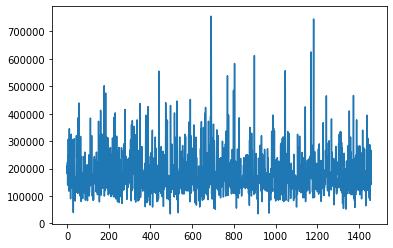

In [224]:
plt.plot(train["SalePrice"])

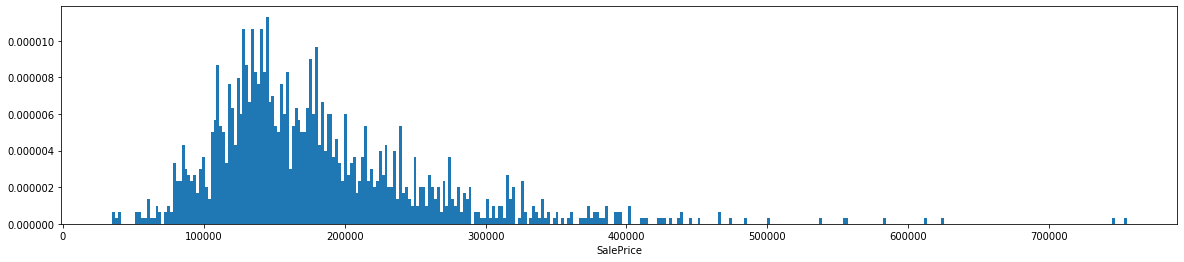

In [225]:
# Then we plot this graph to see if there are any outliers

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20.0
fig_size[1] = 4.0

plt.hist(train['SalePrice'], density=True,bins=350)
plt.xlabel('SalePrice');

It turns out some of the houses are really expensive. Therefore, we do not want to include them in our training set.
We will remove every house which are expensive than 400,000

In [226]:
train = train[train['SalePrice'] < 400000]
train.shape


(1432, 76)

We removed 27 houses to reduce outliers

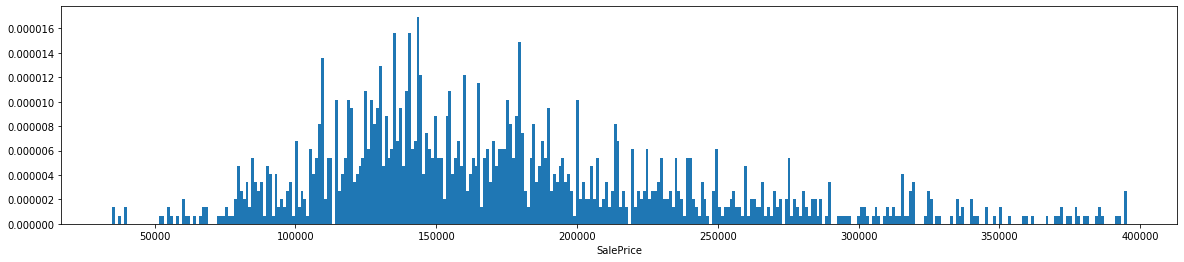

In [227]:
# Let's plot the graph again to see if the outliers got removed
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20.0
fig_size[1] = 4.0

plt.hist(train['SalePrice'], density=True,bins=350)
plt.xlabel('SalePrice');

We want to fill NaN values with medians of respective columns for the numeric data.


In [228]:
train = train.fillna(train.median())
test = test.fillna(test.median())

In [229]:
# Counts how many NaN objects there are in a dataset
nan_train = train.isnull().sum().sum()
nan_test = test.isnull().sum().sum()
print(nan_train,nan_test)

1209 1285


(GarageFinish, BsmtQual, GarageType, GarageQual, GarageCond, BsmtCond, BsmtExposure, BsmtFinType1, FireplaceQu) columns include rest of our NaN data. So, we want to replace the NaN values for most frequent value in that column.

In [230]:

columns = ['GarageFinish', 'BsmtQual', 'GarageType', 'GarageQual', 'GarageCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'FireplaceQu']
for i in columns:
    train = train.fillna(train[i].value_counts().index[0]) # Fills our NaN values with most frequent value
    test = test.fillna(train[i].value_counts().index[0]) # Fills our NaN values with most frequent value
nan_train = train.isnull().sum().sum()
nan_test = test.isnull().sum().sum()
print(nan_train,nan_test)


0 0


We got rid of all of the NaN values

## Now we have to encode the categorical data for training set

In [231]:
# We have to turn our categorical values to numerical values
train = pd.get_dummies(train, columns=['FireplaceQu','MSZoning','Street','LotShape','LandContour',
'Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir',
'Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive',
'SaleType','SaleCondition'])  

In [232]:
train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,1,0,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,1,0,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,1,0,0,0,0,1,0


## Now we want to seperate our training set to X_train and Y_train


In [233]:
X_train = train.drop(['SalePrice'], axis=1)
Y_train = train['SalePrice']

In [234]:
X_train.shape

(1432, 284)

In [235]:
Y_train.shape

(1432,)

The following were missing in Test data after the the one-hot-encoding conversion, therefore they will be dropped from Train data in order to keep Train and Test data "equal". 

In [236]:
X_train = X_train.drop(['Utilities_NoSeWa', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin',
'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW', 'Electrical_Mix', 'Electrical_Unf', 'GarageQual_Ex'], axis=1)

## Now we have to encode the categorical data for test set

In [237]:
test = pd.get_dummies(test, columns=['FireplaceQu','MSZoning','Street','LotShape','LandContour','Utilities',
'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl',
'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
'BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType',
'GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition'])

Now we are going to create our X_test


In [238]:
X_test = test.drop(["Id"], axis=1)

In [239]:
X_test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_Unf,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,1,0,0,0,0,1,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1455,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,0,0,0,1,1,0,0,0,0,0
1456,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,0,0,0,1,1,0,0,0,0,0
1457,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [240]:
# We want to check if there are any NaN values just to be sure
X_test.isnull().sum().sum()

0

The following were missing in Train data after the the one-hot-encoding conversion, therefore they will be dropped from Test data in order to keep Train and Test data "equal". 

In [241]:
X_test = test.drop(['MSZoning_Unf', 'Utilities_Unf', 'Exterior1st_Unf', 'Exterior2nd_Unf', 'KitchenQual_Unf', 
'Functional_Unf', 'SaleType_Unf', 'Id'], axis = 1)


## NOW WE CAN START TRAINING OUR MODEL


In [242]:

reg = XGBRegressor(n_estimators=1000, learning_rate=0.05)
reg.fit(X_train, Y_train)
predictions = reg.predict(X_test)


[19:56:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [243]:
# Create a new dataframe with only the columns Kaggle wants from the data set which are Id and SalePrice
submission = pd.DataFrame({"Id": test["Id"], "SalePrice": predictions})

submission.to_csv("kaggle_HousePricesOutputXGB.csv", index=False)